Importação de bibliotecas necessárias

In [61]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import json

In [62]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D;
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow import keras

from tensorflow.keras.models import model_from_json

Verificação de uso de GPU 

In [63]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 544026621149102072
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5949620224
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12959164752323825258
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [64]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [65]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [66]:
print(tf.__version__)

2.9.0


Abrindo os dados processados

In [67]:
with open("tokenizer.json", "r") as jsonfile:
    tokenizer = json.load(jsonfile)

tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer)

In [68]:
with open("dados/assuntoTratado.csv", "r") as csvfile:
    assuntos = np.genfromtxt(csvfile, delimiter=",")
    assuntos = assuntos.astype(np.int32)

In [69]:
with open("dados/conteudoTratado.csv", "r") as csvfile:
    conteudos = np.genfromtxt(csvfile, delimiter=",")
    conteudos = conteudos.astype(np.int32)

In [70]:
vocab = len(tokenizer.word_index)

In [71]:
maxContent = max(len(tokens) for tokens in conteudos)
maxSubject = len(np.unique(assuntos))

Gerando os valores categóricos das dummies

In [72]:
assuntos = pd.get_dummies(assuntos).values

Separação de dados entre treino, validação e teste. Cada separação de dados possuí todos os 5 valores categóricos diferentes, garantindo que todos sejam testados

In [73]:
size = len(conteudos)

#Treino: 70%
xTrain = conteudos[0:int(size*0.7)]
yTrain = assuntos[0:int(size*0.7)]

#Validação: 10%
xVal = conteudos[int(size*0.7):int(size*0.8)]
yVal = assuntos[int(size*0.7):int(size*0.8)]

#Teste: 20%
xTest = conteudos[int(size*0.8):]
yTest = assuntos[int(size*0.8):]

In [74]:
vocab

92754

In [75]:
model = Sequential()

model.add(Embedding(vocab, 256, input_length = maxContent)),
model.add(Conv1D(64, 3, activation = "relu")),
model.add(MaxPooling1D(3)),
model.add(Conv1D(32, 3, activation = "relu")),
model.add(GlobalMaxPooling1D()),
model.add(Dense(5, activation = "softmax"))

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5476, 256)         23745024  
                                                                 
 conv1d_2 (Conv1D)           (None, 5474, 64)          49216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1824, 64)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 1822, 32)          6176      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 5)                

In [77]:
model.compile(optimizer="adam", loss = "categorical_crossentropy", metrics=["accuracy"])

In [78]:
subjectModel = 'subjectModel.h5'
subjectModelJson = 'subjectModel.json'

In [79]:
modeljson = model.to_json()
with open(subjectModelJson, 'w') as json_file:
  json_file.write(modeljson)

Funções de callback chamadas no treinamento

In [80]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.9, patience=3, verbose = 1)
#lr_reducer é uma função que diminui a taxa de aprendizado, quando o treinamento atinge um "plateau", ou uma linha reta no gráfico de validaton_loss

early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
#early_stopper evita que o modelo treine épocas desnecessárias, ou seja, quando em 8 épocas neste caso, o modelo não avance significativamente na sua validation_loss, o treinamento para

checkpointer = ModelCheckpoint(subjectModel, monitor='val_loss', verbose = 1, save_best_only=True)
#o checkpointer garante que o modelo seja salvo constantemente durante o treinamento

Treinamento da rede neural, com 20 épocas, com batch_size único

In [21]:
neuralNetwork = model.fit(xTrain, yTrain, validation_data = (xVal, yVal), epochs=20, batch_size=1, callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/20
7072/7072 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.9036
Epoch 1: val_loss improved from inf to 0.29737, saving model to subjectModel.h5
7072/7072 [==============================] - 155s 22ms/step - loss: 0.2873 - accuracy: 0.9036 - val_loss: 0.2974 - val_accuracy: 0.9021 - lr: 0.0010
Epoch 2/20
7071/7072 [============================>.] - ETA: 0s - loss: 0.0901 - accuracy: 0.9717
Epoch 2: val_loss did not improve from 0.29737
7072/7072 [==============================] - 149s 21ms/step - loss: 0.0900 - accuracy: 0.9717 - val_loss: 0.3032 - val_accuracy: 0.9199 - lr: 0.0010
Epoch 3/20
7071/7072 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9900
Epoch 3: val_loss did not improve from 0.29737
7072/7072 [==============================] - 142s 20ms/step - loss: 0.0331 - accuracy: 0.9900 - val_loss: 1.0872 - val_accuracy: 0.8388 - lr: 0.0010
Epoch 4/20
7072/7072 [==============================] - ETA: 0s - loss: 0.0215 - accu

Plot do gráfico do avanço das variáveis de loss, e valdiation loss.

In [26]:
plt.plot(neuralNetwork.history['loss'], label = 'loss')
plt.plot(neuralNetwork.history["val_loss"], label = "validation loss")
plt.legend()

NameError: name 'neuralNetwork' is not defined

Plot do gráfico do avanço das variáveis de accuracy, e valdiation accuracy.

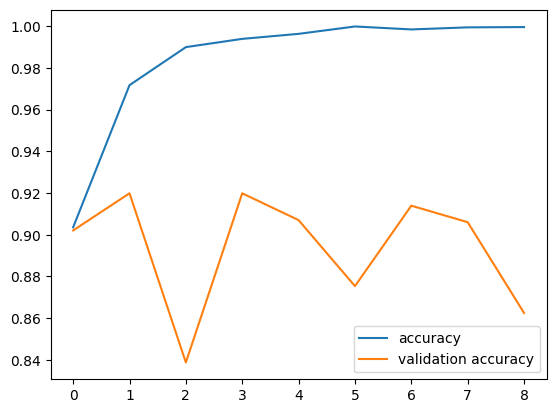

In [ ]:
plt.plot(neuralNetwork.history['accuracy'], label = 'accuracy')
plt.plot(neuralNetwork.history["val_accuracy"], label = "validation accuracy")
plt.legend()

Recarregamento do modelo, para que não seja necessário executar o treinamento novamente toda vez que for necessário rodar trechos de código novamente

In [86]:
from tensorflow.keras.models import model_from_json

with open('modelo/subjectModel.json', 'r') as json_file:
  model = model_from_json(json_file.read())

model = tf.keras.models.load_model('modelo/subjectModel.h5')

Labels dos assuntos do banco de dados

In [87]:
assuntoTxt = ["economia", "esportes", "politica", "famosos","tecnologia"]

Nas próximas linhas seguem exemplos de uma predição do modelo

In [88]:
idx = 0

In [89]:
inputPred = xTest[idx].reshape(1, maxContent)

In [90]:
#corpo do texto da notícia
tokenizer.sequences_to_texts(inputPred)

['logo após vencer sua quarta liga dos campeões com o real madrid o atacante cristiano ronaldo deu a entender que a vitória sobre o liverpool neste sábado pode ter sido sua última partida pelo clube espanhol o importante era ganhar e entrar na história isso era o importante agora é hora de aproveitar o momento vou comemorar e nos dias seguintes darei uma resposta aos torcedores que estão sempre do meu lado foi muito bonito estar no real madrid disse o camisa 7 ao canal bein sports o repórter perguntou então se a resposta era uma despedida e o craque fez mais mistério o programa el chiringuito de grande repercussão na espanha também abordou cristiano após a entrevista ao bein e o questionou se o craque tem dúvidas sobre o futuro não tenho dúvidas isso não é importante de verdade é hora de aproveitar descansar e ir para a seleção na próxima semana já veremos o que acontecerá o importante é a história que o real fez o camisa 7 aproveitou ainda a conversa com o el chiringuito para tirar on

In [91]:
prediction = model.predict(inputPred)

1/1 [==============================] - 0s 175ms/step


In [92]:
prediction

array([[7.9191568e-07, 9.9933356e-01, 7.0126957e-06, 6.3864392e-04,
        1.9915127e-05]], dtype=float32)

In [93]:
assuntoTxt[yTest[idx].argmax()]

'esportes'

In [94]:
assuntoTxt[prediction.argmax()]

'esportes'

In [95]:
scores = model.evaluate([xTest[0:2019]], [yTest[0:2019]])

64/64 [==============================] - 2s 24ms/step - loss: 0.2713 - accuracy: 0.9054


In [96]:
scores
#loss e accuracy, respectivamente

[0.2712879478931427, 0.9053987264633179]

tratamento de dados e geração de predições para a criação de uma matriz de confusão

In [97]:
yPred = []
for x in xTest:

    yPred.append(       
        model.predict(x.reshape(1, maxContent))[0].argmax()   
        )
    

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 13ms/step


In [98]:
yTestNumeric = []

for y in yTest:
    yTestNumeric.append(y.argmax())

In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [100]:
confMatrix = confusion_matrix(yTestNumeric, yPred)

In [101]:
confMatrix

array([[426,   8,  20,   0,  35],
       [  0, 628,   0,   1,   0],
       [ 65,   2, 416,   0,   2],
       [  1,  12,   0, 207,   8],
       [ 30,   6,   2,   0, 152]], dtype=int64)

Porcentagem de erro, respectivamente em cada um dos assuntos, respectivamente

In [102]:
totals = np.sum(confMatrix[:], axis=1)
trues = []

for i in range(5):
    trues.append(confMatrix[i][i])

(totals-trues)/totals*100

array([12.88343558,  0.15898251, 14.22680412,  9.21052632, 20.        ])

Matriz de confusão

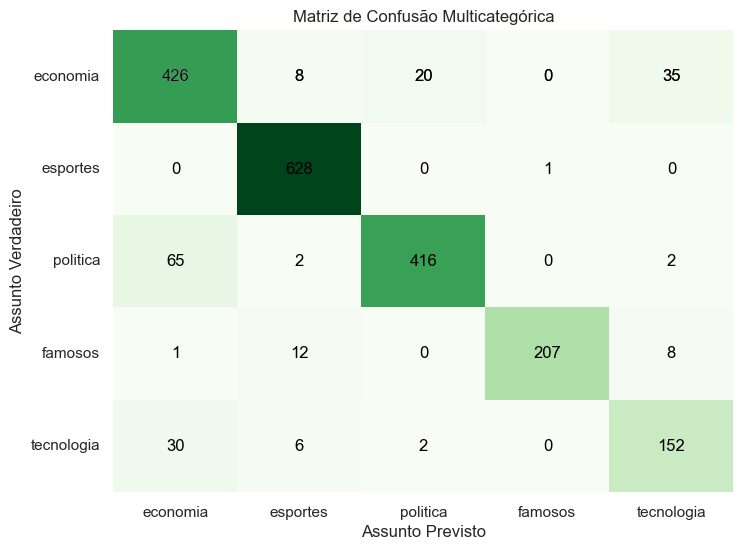

In [103]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(confMatrix, annot=True, fmt="d", cmap="Greens", cbar=False)

for i in range(len(confMatrix)):
    for j in range(len(confMatrix[i])):
        plt.text(j + 0.5, i + 0.5, confMatrix[i, j],
                 ha='center', va='center', color='black')

heatmap.set_xticklabels(assuntoTxt, rotation=0)
heatmap.set_yticklabels(assuntoTxt, rotation=0)

plt.title('Matriz de Confusão Multicategórica')
plt.xlabel('Assunto Previsto')
plt.ylabel('Assunto Verdadeiro')

plt.show()

In [104]:
assuntoTxt

['economia', 'esportes', 'politica', 'famosos', 'tecnologia']